In [1]:
import pandas as pd
import numpy as np
import hashlib
from collections.abc import Iterable
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import time

# define gvars
SEED = 1080
VCHUNK = 64

# import from csv to dataframe
df = pd.read_csv('wnl/WNL_TLS_Dataset_ECH.csv', sep='\t')



In [2]:
df.head()

#df.Label.unique()

,Label,ClientHello,ServerHello
0,AppleMusic,"22,3,1,0,166,1,0,0,162,3,3,0,0,0,0,147,162,126...","22,3,3,0,122,2,0,0,118,3,3,0,0,0,0,219,104,67,..."
1,AppleMusic,"22,3,1,1,213,1,0,1,209,3,3,0,0,0,0,153,108,195...","22,3,3,0,128,2,0,0,124,3,3,0,0,0,0,174,105,135..."
2,AppleMusic,"22,3,1,0,166,1,0,0,162,3,3,0,0,0,0,72,145,151,...","22,3,3,0,122,2,0,0,118,3,3,0,0,0,0,197,217,247..."
3,AppleMusic,"22,3,1,1,213,1,0,1,209,3,3,0,0,0,0,14,243,79,3...","22,3,3,0,128,2,0,0,124,3,3,0,0,0,0,73,224,90,8..."
4,AppleMusic,"22,3,1,1,213,1,0,1,209,3,3,0,0,0,0,24,22,171,9...","22,3,3,0,128,2,0,0,124,3,3,0,0,0,0,244,91,185,..."


In [3]:
'''https://tls13.xargs.org/#client-hello/annotated'''

def flatten(L):
    '''flattens a list of nested list of arbitrary depth into a single concatenated list'''
    for x in L:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

def padding(A, size):
    '''pads a given list to a given length'''
    t = size - len(A)

    return np.pad(A, pad_width=(0, t), mode='constant')

def parse_CHP(p):
    '''
    implements the Shamsimukhametov et al. bytes recomposition algorithm
    builds a fixed length feature vector from clienthello message
    '''
    T = []
    L = []
    V = []

    handshake_len = sum(p[3:5])
    clienthello_len = sum(p[6:9])
    sid_len = p[43]
    i = 44+sid_len

    sid = p[44:i]
    ciphersuite_len = sum(p[i:i+2])
    ciphersuite = p[i+2:i+2+ciphersuite_len]
    i += 4 + ciphersuite_len

    ext_len = sum(p[i:i+2])
    i = i+2
    
    T.append(padding(sid, 32))
    L.append(handshake_len)
    L.append(clienthello_len)
    L.append(sid_len)
    L.append(ciphersuite_len)
    L.append(ext_len)
    V.append(ciphersuite)
    
    end = i + ext_len
    count = 0   

    while (i < len(p)):

        n_ext_id = sum(p[i:i+2])
        i+=2
        
        n_ext_len = sum(p[i:i+2])
        i+=2

        T.append(n_ext_id)
        L.append(n_ext_len)
        V.append(p[i:i+n_ext_len])
        i+=n_ext_len

    T = padding(list(flatten(T)),40)
    L = padding(list(flatten(L)),13)
    V = list(flatten(V))
    VC = V[:VCHUNK]

    return np.concatenate((T,L,VC))

def parse_SHP(p):
    '''
    implements the Shamsimukhametov et al. bytes recomposition algorithm
    builds a fixed length feature vector from serverhello message
    '''
    T = []
    L = []
    V = []

    handshake_len = sum(p[3:5])
    serverhello_len = sum(p[6:9])
    sid_len = p[43]
    i = 44+sid_len

    sid = p[44:i]
    ciphersuite = sum(p[i:i+2])
    i += 3

    ext_len = sum(p[i:i+2])
    i = i+2
    
    T.append(padding(sid, 32))
    T.append(ciphersuite)
    L.append(handshake_len)
    L.append(serverhello_len)
    L.append(sid_len)
    L.append(ext_len)

    end = i + ext_len
    count = 0    
    
    while (i < len(p)):

        n_ext_id = sum(p[i:i+2])
        i+=2
        
        n_ext_len = sum(p[i:i+2])
        i+=2

        T.append(n_ext_id)
        L.append(n_ext_len)
        V.append(p[i:i+n_ext_len])
        i+=n_ext_len

    T = padding(list(flatten(T)),40)
    L = padding(list(flatten(L)),10)
    V = list(flatten(V))
    VC = V[:VCHUNK]

    return np.concatenate((T,L,VC))

def parse_payload(CH,SH):
    '''builds a concatenated fixed length feature vector of recomposed bytes'''
    chp  = np.fromstring(CH, dtype=int, sep=',')
    shp  = np.fromstring(SH, dtype=int, sep=',')
    chv = parse_CHP(chp)
    shv = parse_SHP(shp)
    return np.concatenate((chv,shv))

In [4]:
# Transform according to recomposition algorithm
df['X'] = df.apply(lambda row : parse_payload(row['ClientHello'], row['ServerHello']), axis=1)
sample = df.X[0]
print(sample)
print(len(sample))

[132 119 186 235 186   2 164 141 185  92  21 164  31 142 242 106 128 185
  45  92  59 161 173 181  15 236 118 178 145  29 148 199  51  43   0   0
   0   0   0   0 166 162  32  34  55  38   9   0   0   0   0   0   0  19
   1  19   2  19   3 192  43 192  44 204 169 192  47 192  48 204 168 192
   9 192  10 192  19 192  20   0 156   0 157   0  47   0  53   0  36   0
  29   0  32 128  70 186 232  48 147  53 217 219 145  14  93 217 193 220
 251 228 172 113 190 211  40 106  94 132 119 186 235 186   2 164 141 185
  92  21 164  31 142 242 106 128 185  45  92  59 161 173 181  15 236 118
 178 145  29 148 199  20  43  51   0   0   0   0   0 122 118  32  46   2
  36   0   0   0   0   3   4   0  29   0  32 179 169  38  12  73  68  45
 171  35  59  24  99  89 181  22  35  31 149 206  44 227 135  92 156 245
 202  29  57 124  67 142  93]
205


In [5]:
# Encode classes into integers as terget variable vector y
labels = df.Label.unique()
df['Label'] = df['Label'].astype('category')
df['target'] = df['Label'].cat.codes
y = df['target'].to_numpy()

In [6]:
# expand array to proper dims
dfx = pd.DataFrame(df['X'].tolist()).add_prefix("x")
X = dfx.to_numpy(dtype=np.int16)

In [7]:
# split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED, shuffle=True, stratify=y)

In [8]:
rf_opt_model = RandomForestClassifier(  criterion='entropy', 
                                        max_depth=7, 
                                        max_features=None, 
                                        min_samples_leaf=2, 
                                        min_samples_split=7, 
                                        n_estimators=130,
                                        n_jobs=-1, 
                                        random_state=SEED)
# start timing
start = time.time()

# fit the base estimator
rf_opt_model.fit(X_train,y_train)
# stop timing
end = time.time()

In [9]:
# Make predictions on our test data
y_pred = rf_opt_model.predict(X_test)

In [10]:
# Evaluate the models performance (I hope this isnt garbage)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

              precision    recall  f1-score   support

  AppleMusic     0.8545    1.0000    0.9216        47
         Web     0.6452    0.9231    0.7595        65
   Kinopoisk     1.0000    1.0000    1.0000        27
LiveFacebook     1.0000    1.0000    1.0000        27
 LiveYouTube     0.7955    1.0000    0.8861       105
     Netflix     0.9744    0.8444    0.9048        45
  PrimeVideo     0.9437    0.9853    0.9640        68
  SoundCloud     0.8923    0.9831    0.9355        59
     Spotify     0.8571    0.7826    0.8182        23
       Vimeo     0.9602    0.7598    0.8484       254
 YandexMusic     0.8462    0.7253    0.7811        91
     YouTube     0.9688    1.0000    0.9841        62

    accuracy                         0.8797       873
   macro avg     0.8948    0.9170    0.9003       873
weighted avg     0.8946    0.8797    0.8792       873



In [11]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Training Time: "+str(end-start))

Accuracy: 0.8797250859106529
Training Time: 1.0212576389312744


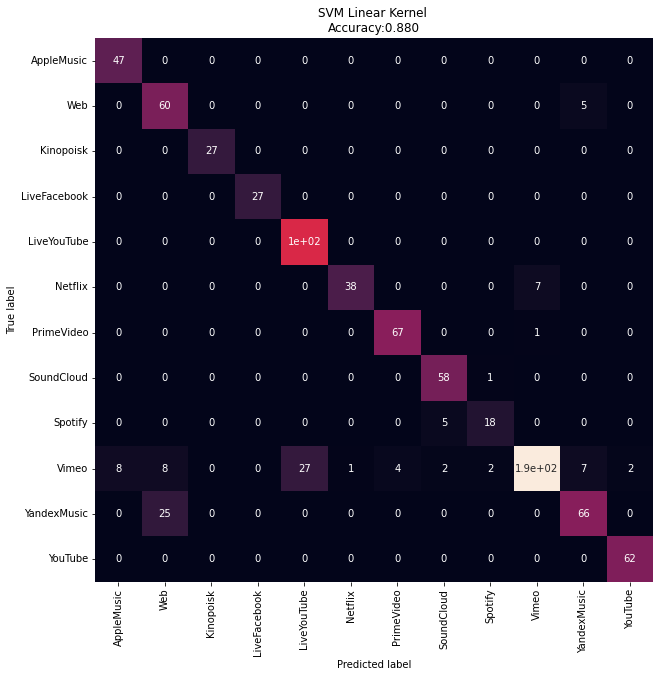

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns


# plot a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = labels, columns = labels)

plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, cbar=False)
plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()